In [1]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%%capture
# Install the latest Tensorflow version.
!pip3 install --upgrade tensorflow-gpu
# Install TF-Hub.
!pip3 install tensorflow-hub

In [0]:
from pathlib import Path
import re
import importlib
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle

import tensorflow as tf
import tensorflow_hub as hub
# Reduce logging output
from absl import logging
logging.set_verbosity(logging.ERROR)

In [0]:
# Inference model
MODULE_URL = 'https://tfhub.dev/google/universal-sentence-encoder/4'
# Inference batch size
MAX_BATCH_SIZE = 1024

In [0]:
MAIN_DIR = Path('drive/My Drive/Colab Notebooks/transformers/MoviePlots')
DATA_FILE = MAIN_DIR/'data'/'data.pkl'

MODEL_DIR = MAIN_DIR/'text_generation'/'GPT-2-huggingface'
DUMPS_DIR = MODEL_DIR/'dumps'
CACHE_DIR = MODEL_DIR/'eval_cache'
CACHE_DIR.mkdir(exist_ok=True)

## Import training data

In [0]:
with open(DATA_FILE, 'rb') as handle:
    train_data = pickle.load(handle)

In [7]:
train_df = pd.DataFrame(train_data)

print(train_df.head())

                                               title  ...                      secondary
0                               "#7DaysLater" (2013)  ...                           None
1       "#BlackLove" (2015) {Crash the Party (#1.9)}  ...                Crash the Party
2  "#BlackLove" (2015) {Making Lemonade Out of Le...  ...  Making Lemonade Out of Lemons
3      "#BlackLove" (2015) {Miss Independent (#1.5)}  ...               Miss Independent
4     "#BlackLove" (2015) {Sealing the Deal (#1.10)}  ...               Sealing the Deal

[5 rows x 7 columns]


## Parse dumps

In [8]:
# Import title_extraction
spec = importlib.util.spec_from_file_location('title_extraction', MAIN_DIR/'title_extraction.py')
title_extraction = importlib.util.module_from_spec(spec)
spec.loader.exec_module(title_extraction)
title_extraction

<module 'title_extraction' from 'drive/My Drive/Colab Notebooks/transformers/MoviePlots/title_extraction.py'>

In [0]:
EOS_TOKEN = '<|endoftext|>'
EOG_TOKEN = '<|endofgenre|>'
EOT_TOKEN = '<|endoftitle|>'

In [10]:
dump_files = list(DUMPS_DIR.glob('*.txt'))

dump_files

[PosixPath('drive/My Drive/Colab Notebooks/transformers/MoviePlots/text_generation/GPT-2-huggingface/dumps/temp_0_7_topp_0.txt'),
 PosixPath('drive/My Drive/Colab Notebooks/transformers/MoviePlots/text_generation/GPT-2-huggingface/dumps/temp_0_7_topp_0_9.txt'),
 PosixPath('drive/My Drive/Colab Notebooks/transformers/MoviePlots/text_generation/GPT-2-huggingface/dumps/temp_1_topp_0.txt'),
 PosixPath('drive/My Drive/Colab Notebooks/transformers/MoviePlots/text_generation/GPT-2-huggingface/dumps/temp_1_topp_0_9.txt'),
 PosixPath('drive/My Drive/Colab Notebooks/transformers/MoviePlots/text_generation/GPT-2-huggingface/dumps/temp_1_3_topp_0.txt'),
 PosixPath('drive/My Drive/Colab Notebooks/transformers/MoviePlots/text_generation/GPT-2-huggingface/dumps/temp_1_3_topp_0_9.txt')]

In [0]:
def extract_data(line):
    """Extract the data from a line generated by the model."""
    main = line.split(EOS_TOKEN)[0]
    genre = main.split(EOG_TOKEN)[0].strip()
    title = main.split(EOG_TOKEN)[1].split(EOT_TOKEN)[0].strip()
    plot = main.split(EOG_TOKEN)[1].split(EOT_TOKEN)[1].strip()
    return {
        'genre': genre,
        'title': title,
        'plot': plot,
        'year': title_extraction.extract_year(title),
        'episode': title_extraction.extract_episode(title),
        'primary': title_extraction.extract_primary_title(title),
        'secondary': title_extraction.extract_secondary_title(title)
    }

In [0]:
def parse_fname(fname):
    """Parse the name of a file for temperature and top_p."""
    pattern = r'temp_(.+)_topp_(.+).txt'
    match = re.search(pattern, dump_files[0].name)
    temp, topp = match.groups()
    temp = float(temp.replace('_', '.'))
    topp = float(topp)
    return temp, topp

In [13]:
gen_data = []
for dump_file in dump_files:
    with dump_file.open() as f:
        for line in f:
            try:
                data_dict = extract_data(line)
                temp, topp = parse_fname(dump_file.name)
                data_dict['temp'] = temp
                data_dict['topp'] = topp
                gen_data.append(data_dict)
            except:
                pass

print(len(gen_data))

1613


In [14]:
gen_df = pd.DataFrame(gen_data)

print(gen_df.head())

    genre                                              title  ... temp  topp
0  action  "Teenage Mutant Ninja Turtles" (1987) {The Bat...  ...  0.7   0.0
1  action                      "Fossil Gina" (2012) {(#1.1)}  ...  0.7   0.0
2  action  "The Twilight Zone" (1959) {The City of Angels...  ...  0.7   0.0
3  action  "The Human Target" (2009) {The Return of the H...  ...  0.7   0.0
4  action  "Blaster" (2013) {Called to the Rescue: Part 1...  ...  0.7   0.0

[5 rows x 9 columns]


## Calculate similarity

### Jaccard similarity

In [0]:
def jaccard_similarity(str1, str2):
    """Jacard similarity, or, how overfit is our data?..."""
    s1 = set(str1.split(' '))
    s2 = set(str2.split(' '))
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [0]:
def similarity_matrix(column, similarity_func, overwrite=False):
    """Calculate the pairwise similarity between texts of two lists."""
    # It's important to preserve the order of columns and index to compare multiple matrices later
    fpath = CACHE_DIR/(column + '.npz')
    if fpath.exists() and not overwrite:
        print("Loading from cache...")
        # Do not forget to uncompress
        return np.load(fpath)['sim_matrix']
    pbar = tqdm(total=len(gen_df.index)*len(train_df.index))
    # Fill similarity matrix
    # We can compress our matrix to float16:
    # Since the values are always in [0, 1] with maximum step of 1/256 (for jaccard_similarity)
    sim_matrix = np.empty((len(gen_df.index), len(train_df.index)), dtype=np.float16)
    sim_matrix[:, :] = np.nan
    for i, t1 in enumerate(gen_df[column]):
        for j, t2 in enumerate(train_df[column]):
            if t1 not in (None, '') and t2 not in (None, ''):
                sim_matrix[i, j] = similarity_func(t1, t2)
            pbar.update()
    pbar.close()
    # Reduce file size by applying NumPy compression
    np.savez_compressed(fpath, sim_matrix=sim_matrix)
    return sim_matrix

In [17]:
# Primary title similarity
primary_jm = similarity_matrix('primary', jaccard_similarity)

print(primary_jm.shape)

Loading from cache...
(1613, 117193)


In [18]:
# Secondary title similarity
secondary_jm = similarity_matrix('secondary', jaccard_similarity)

print(secondary_jm.shape)

Loading from cache...
(1613, 117193)


In [19]:
# Plot similarity
plot_jm = similarity_matrix('plot', jaccard_similarity)

print(plot_jm.shape)

Loading from cache...
(1613, 117193)


### Universal sentence encoder

In [0]:
# Load inference model
model = hub.load(MODULE_URL)

In [0]:
def compute_embeddings(texts, fname, overwrite=False):
    """Compute a representation for each text."""
    fpath = CACHE_DIR/(fname + '.npz')
    if fpath.exists() and not overwrite:
        print("Loading from cache...")
        return np.load(fpath)['embeddings']
    embeddings = []
    for i in tqdm(range(0, len(texts), MAX_BATCH_SIZE)):
        embeddings.append(np.array(model(texts[i:i+MAX_BATCH_SIZE])))
    # np.inner has problems with np.float16
    embeddings = np.vstack(embeddings).astype(np.float32)
    assert(embeddings.shape[0] == len(texts))
    np.savez_compressed(fpath, embeddings=embeddings)
    return embeddings

In [28]:
gen_plot_embeddings = compute_embeddings(gen_df['plot'], 'gen_plot_embeddings')

print(gen_plot_embeddings.shape)

Loading from cache...
(1613, 512)


In [29]:
train_plot_embeddings = compute_embeddings(train_df['plot'], 'train_plot_embeddings')

print(train_plot_embeddings.shape)

Loading from cache...
(117193, 512)


In [24]:
%%time
# Compute pairwise similarity
plot_em = np.inner(gen_plot_embeddings, train_plot_embeddings)

print(plot_em.shape)

(1613, 117193)
CPU times: user 5.89 s, sys: 257 ms, total: 6.14 s
Wall time: 1.72 s


### Stack matrices

In [25]:
# Stack matrices together
jm = np.stack([primary_jm, secondary_jm, plot_jm, plot_em], axis=2)

print(jm.shape)

(1613, 117193, 4)


In [0]:
# Release RAM
del primary_jm
del secondary_jm
del plot_jm

In [27]:
# Some generated titles/plots are empty or NaN
# Do not check secondary titles since they are allowed to be empty
primary_valid_mask = gen_df['primary'].apply(lambda x: x not in (None, ''))
plot_valid_mask = gen_df['plot'].apply(lambda x: x not in (None, ''))
valid_mask = primary_valid_mask & plot_valid_mask

jm = jm[valid_mask, :, :]

print(jm.shape)

(1608, 117193, 4)


## Evaluate similarity

In [30]:
# The most similar and dissimilar generated titles
jm_max_df = pd.DataFrame(np.nanmax(jm, axis=1), columns=['primary_j', 'secondary_j', 'plot_j', 'plot_e'])

print(jm_max_df.head())

   primary_j  secondary_j    plot_j    plot_e
0   1.000000     0.666504  0.169189  0.698506
1   0.333252          NaN  0.215332  0.679386
2   1.000000     0.750000  0.189209  0.590162
3   0.666504     0.571289  0.223022  0.707462
4   0.000000     0.500000  0.173340  0.727730


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: All-NaN slice encountered
  """Entry point for launching an IPython kernel.


In [31]:
# The relative number of NaNs among each part
jm_max_df.isnull().mean()

primary_j      0.000000
secondary_j    0.254975
plot_j         0.000000
plot_e         0.000000
dtype: float64

In [32]:
jm_max_df.index = gen_df.loc[valid_mask, 'primary'].tolist()

print(jm_max_df['primary_j'].sort_values())

hapoha carnival     0.0
Dagmarje            0.0
Provocative         0.0
1996                0.0
Inevitably          0.0
                   ... 
The Outer Limits    1.0
CSI: Miami          1.0
Diagnosis Murder    1.0
Teen Wolf           1.0
Wallander           1.0
Name: primary_j, Length: 1608, dtype: float32


In [33]:
jm_max_df.index = gen_df.loc[valid_mask, 'secondary'].tolist()

# Select only titles 
print(jm_max_df.loc[~jm_max_df['secondary_j'].isnull(), 'secondary_j'].sort_values())

Pambling            0.0
Kakiswara           0.0
Rampoku             0.0
Envisions           0.0
Eon                 0.0
                   ... 
The Party's Over    1.0
Art                 1.0
Josh                1.0
A Place to Die      1.0
The Comeback Kid    1.0
Name: secondary_j, Length: 1198, dtype: float32


In [34]:
jm_max_df.index = gen_df.loc[valid_mask, 'plot'].tolist()

print(jm_max_df['plot_j'].sort_values())

Forman cuppe grâme (#1.6)}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [35]:
jm_max_df.index = gen_df.loc[valid_mask, 'plot'].tolist()

print(jm_max_df['plot_e'].sort_values())

Genes uit chom rect chin wedugenbed van Automar 96 (#8.2)}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [36]:
# The average similarity of generated titles to the real ones
jm_max_df.mean(axis=0)

primary_j      0.696498
secondary_j    0.499556
plot_j         0.153762
plot_e         0.614106
dtype: float32

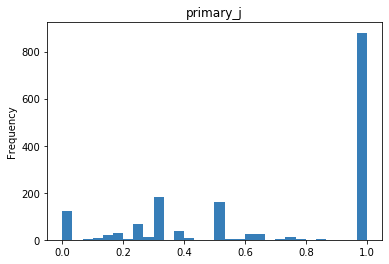

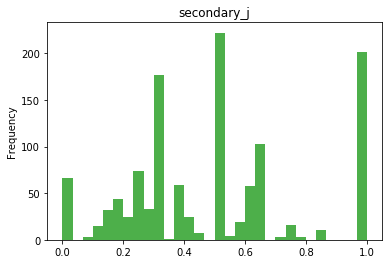

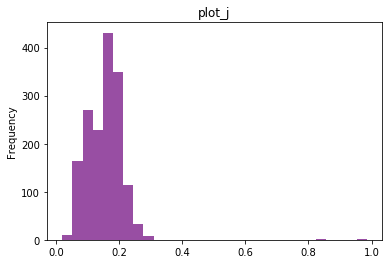

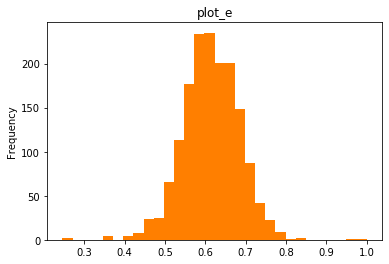

In [37]:
jm_max_df['primary_j'].plot.hist(bins=30, title='primary_j', color=plt.cm.Set1(0.15))
plt.show()
jm_max_df['secondary_j'].plot.hist(bins=30, title='secondary_j', color=plt.cm.Set1(0.25))
plt.show()
jm_max_df['plot_j'].plot.hist(bins=30, title='plot_j', color=plt.cm.Set1(0.35))
plt.show()
jm_max_df['plot_e'].plot.hist(bins=30, title='plot_e', color=plt.cm.Set1(0.45))
plt.show()

In [38]:
# The number of exact matches
(jm_max_df == 1).mean(axis=0)

primary_j      0.547264
secondary_j    0.125000
plot_j         0.000000
plot_e         0.000000
dtype: float64

In [39]:
# Correlation of similarities on different stages
pd.DataFrame({'primary_j': jm[:, :, 0].flatten(), 
              'secondary_j': jm[:, :, 1].flatten(), 
              'plot_j': jm[:, :, 2].flatten(), 
              'plot_e': jm[:, :, 3].flatten()}).corr()

,primary_j,secondary_j,plot_j,plot_e
primary_j,1.000000,0.059421,0.055486,0.025638
secondary_j,0.059421,1.000000,0.111436,-0.001909
plot_j,0.055486,0.111436,1.000000,0.274617
plot_e,0.025638,-0.001909,0.274617,1.000000


### Grouped by genre

In [0]:
# Extract genre masks
genre_masks = {}
for genre, group in gen_df[valid_mask].groupby(by='genre'):
    gen_mask = gen_df[valid_mask].index.isin(group.index).tolist()
    train_mask = train_df['genres'].apply(lambda x: genre in x).tolist()
    genre_masks[genre] = np.asarray(gen_mask), np.asarray(train_mask)

In [41]:
# How similar are generated texts to training texts with respect to each genre?
print(pd.DataFrame({
    genre: np.nanmean(np.nanmax(jm[gen_mask, :, :][:, train_mask, :], axis=1), axis=0)
    for genre, (gen_mask, train_mask) in genre_masks.items() 
    if any(gen_mask) and any(train_mask)
}, index=['primary_j', 'secondary_j', 'plot_j', 'plot_e']).transpose().sort_values(by='primary_j', ascending=False))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: All-NaN slice encountered
  after removing the cwd from sys.path.


             primary_j  secondary_j    plot_j    plot_e
drama         0.799991     0.387268  0.156703  0.648287
romance       0.797843     0.352496  0.142429  0.637222
thriller      0.580009     0.452093  0.152583  0.620722
mystery       0.569366     0.445463  0.150931  0.616029
sci-fi        0.566007     0.433373  0.143574  0.597198
crime         0.529247     0.475820  0.146446  0.622159
comedy        0.477796     0.386332  0.151382  0.592714
adventure     0.460884     0.344050  0.140731  0.571900
fantasy       0.454172     0.379963  0.140484  0.587274
animation     0.433190     0.384416  0.142031  0.555749
family        0.427470     0.428780  0.135224  0.562412
horror        0.421122     0.262725  0.131128  0.558564
news          0.405049     0.188721  0.121119  0.546652
reality-tv    0.392912     0.311662  0.136342  0.531859
action        0.382468     0.468658  0.150032  0.587946
documentary   0.323565     0.282206  0.125557  0.533790
talk-show     0.319719     0.174543  0.122453  0

In [42]:
# Here is the true distribution the model was trained on
# If both distribution are similar, than the model established the link between genre and title properly
# It also shows which genres are the most expressive
pd.Series([genre for genres in train_df['genres'] for genre in genres]).value_counts()

drama          45890
comedy         33870
romance        19174
family         15403
crime          15120
action         12376
reality-tv     12336
mystery        12025
documentary    12020
animation      11369
adventure      10243
thriller        8852
sci-fi          8658
fantasy         7103
talk-show       5253
news            3945
music           2837
western         2761
history         2662
horror          2571
game-show       2045
sport           1946
war             1407
biography       1385
musical          595
short            578
adult             61
dtype: int64

### Per item similarity difference

In [43]:
# Capture how similarity changed from primary to secondary title
jm_diff = jm[:, :, 1]-jm[:, :, 0]

print(jm_diff.shape)

(1608, 117193)


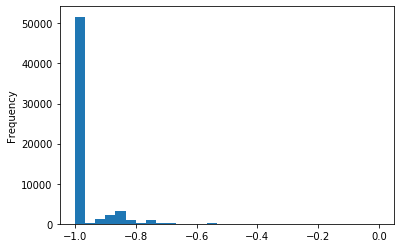

In [44]:
# How similarity changed from perfectly identical primary plots to secondary plots
pd.Series(jm_diff[jm[:, :, 0] == 1]).plot.hist(bins=30)

In [45]:
# If primary titles are identical, how many secondary titles are identical too?
(jm_diff[jm[:, :, 0] == 1] == 0).mean()

2.548744743213967e-05

### The most similar example

In [0]:
# Display the most similar examples according to universal embeddings
gen_i, train_i = np.unravel_index(np.nanargmax(jm[:, :, 3]), jm.shape[:2])

In [47]:
jm[gen_i, train_i, :]

array([0.       ,       nan, 0.984375 , 1.0000001], dtype=float32)

In [48]:
print(gen_df[valid_mask].iloc[gen_i])
print(gen_df[valid_mask].iloc[gen_i]['plot'])

genre                                                talk-show
title                  "What's My Line?" (1950) {(1953-11-15)}
plot         This Hooper Award Winning show is designed wit...
year                                                      1950
episode                                                   None
primary                                        What's My Line?
secondary                                                     
temp                                                       0.7
topp                                                         0
Name: 242, dtype: object
This Hooper Award Winning show is designed with the whole family in mind. The show's host, Jimmie Jackson, known as "Television's Singing Troubadour" is accompanied by the "Memory Lane Orchestra" as they perform nostalgic songs from the past on a musical stroll down "Memory Lane." The show also features "Television's Hollywood Hostess," Anita Coleman who shares the latest Hollywood gossip with her excitin

In [49]:
print(train_df.iloc[train_i])
print(train_df.iloc[train_i]['plot'])

title                      "Memory Lane" (1947) {(1950-07-28)}
plot          This Hooper Award Winning show is designed wi...
genres                                                 {music}
year                                                      1947
episode                                                   None
primary                                            Memory Lane
secondary                                                     
Name: 57590, dtype: object
 This Hooper Award Winning show is designed with the whole family in mind. The show's host, Jimmie Jackson, known as "Television's Singing Troubadour" is accompanied by the "Memory Lane Orchestra" as they perform nostalgic songs from the past on a musical stroll down "Memory Lane." The show also features "Television's Hollywood Hostess," Anita Coleman who shares the latest Hollywood gossip with her exciting celebrity guests. Moppet, J.P. Sloane is also occasionally featured as "Hollywood's Youngest Television Host."
